In [11]:
import pandas as pd 
import numpy as np
import os
import scanpy as sc
import matplotlib.pyplot as plt
import pickle
import scipy

In [167]:
PATH = "params2/"
all_etas = []

for patient in ["R310"]:
    if "_" not in patient:
        print(patient)
        path = os.path.join(PATH, patient)
        eta = pd.read_csv(os.path.join(path + "/eta.csv"), index_col=0)
        Xad = sc.read_h5ad(os.path.join(path + "/X.h5"))

R310


In [168]:
arms = pd.read_csv("GRCh38_cytoBand.txt",sep='\t', header=None)

In [169]:
arms.columns = ["chr","start","end","band","g"]

In [170]:
arms = arms.fillna("NaN")

In [162]:
with open('bands_dict.pkl', 'rb') as f:
    bands = pickle.load(f)

In [163]:
def bin_by_bands(df, column):
    '''
    where df is a genes (index) x clusters matrix, and column specifies the cluster to be analyzed
    '''
    values = []
    keys = []
    draw_lines = []
    counts = 0
    chr = "chr1"
    all_bands = arms["band"]
    all_chr = arms["chr"]
    genes = []
    #loop through each band, taking the mean of all genes in that band
    for i in range(arms.shape[0]):
        if all_bands[i]!="NaN" and all_chr[i]+"_"+all_bands[i] in bands.keys():
            genes_in_chr = np.intersect1d(bands[all_chr[i]+"_"+all_bands[i]],df.index)
            value = np.mean(df.loc[genes_in_chr][column])
            if not pd.isna(value):
                #print(genes_in_chr)
                genes+=list(genes_in_chr)
                values.append(value)
                keys.append(value)
                #track the end of each chromosome
                if all_chr[i]!=chr:
                    draw_lines.append(counts)
                    chr = all_chr[i]
                counts+=1
    return values, draw_lines, genes

from hmmlearn import hmm
def get_states(vals):
    scores = list()
    models = list()

    #if we are in a cluster that has no deletions
    if min(vals)>-1:
        for idx in range(10):  # ten different random starting states
            # define our hidden Markov model
            model = hmm.GaussianHMM(n_components=2, random_state=idx,
                                   n_iter=10)
            model.fit(vals[:, None])
            models.append(model)
            scores.append(model.score(vals[:, None]))
            print(f'Converged: {model.monitor_.converged}\t\t'
                  f'Score: {scores[-1]}')
        
        # get the best model
        model = models[np.argmax(scores)]
        print(f'The best model had a score of {max(scores)} and '
              f'{model.n_components} components')
        
        # use the Viterbi algorithm to predict the most likely sequence of states
        # given the model
        states = model.predict(vals[:, None])

        #figure out which state corresponds to whch CN stattes
        tmp = pd.DataFrame({"vals":vals,"states":states})
        
        state_dict = pd.DataFrame()
        for i in np.unique(states):
            mean = tmp[tmp["states"]==i].mean()
            state_dict[i] = mean
        
        state_dict = state_dict.T.sort_values(by='vals')
        state_dict["CNV"] = ["neut","amp"]
        convert = {state_dict['states'][i]:state_dict["CNV"][i] for i in range(2)}
        
        cnvs = [convert[i] for i in states]
    else:
        for idx in range(10):  # ten different random starting states
            # define our hidden Markov model
            model = hmm.GaussianHMM(n_components=3, random_state=idx,
                                   n_iter=10)
            model.fit(vals[:, None])
            models.append(model)
            scores.append(model.score(vals[:, None]))
            print(f'Converged: {model.monitor_.converged}\t\t'
                  f'Score: {scores[-1]}')
        
        # get the best model
        model = models[np.argmax(scores)]
        print(f'The best model had a score of {max(scores)} and '
              f'{model.n_components} components')
        
        # use the Viterbi algorithm to predict the most likely sequence of states
        # given the model
        states = model.predict(vals[:, None])
        #return states
        #figure out which state corresponds to whch CN stattes
        tmp = pd.DataFrame({"vals":vals,"states":states})
        
        state_dict = pd.DataFrame()
        for i in np.unique(states):
            mean = tmp[tmp["states"]==i].mean()
            state_dict[i] = mean
        
        state_dict = state_dict.T.sort_values(by='vals')
        state_dict["CNV"] = ["del","neut","amp"]
        convert = {state_dict['states'][i]:state_dict["CNV"][i] for i in range(3)}
        
        cnvs = [convert[i] for i in states]
    return cnvs

In [172]:
vals, draw_lines, genes = bin_by_bands(eta, '6')

In [173]:
vals = scipy.stats.zscore(vals)
states = get_states(np.asarray(vals))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.I

In [73]:
infercnv = pd.read_csv("N_infer_full_10.16.21", index_col=0)

In [74]:
infer_inds = [i.split("-")[0] for i in infercnv.index]

infercnv.index = infer_inds

inds = pd.DataFrame(list(np.unique(infer_inds,return_counts=True)[0]))
inds["counts"]=np.unique(infer_inds,return_counts=True)[1]

inds = inds[inds['counts']==1]

infercnv = infercnv.loc[inds[0]]

X_inds = [i.split("-")[0] for i in Xad.obs_names]
Xad.obs_names=X_inds

x_inds = pd.DataFrame(list(np.unique(X_inds,return_counts=True)[0]))
x_inds["counts"]=np.unique(X_inds,return_counts=True)[1]
x_inds = x_inds[x_inds['counts']==1]

tmp_X = Xad.obs.loc[x_inds[0]]

clusters = pd.DataFrame(tmp_X["leiden"])
clusters.index = tmp_X.index

infercnv = infercnv.loc[np.intersect1d(x_inds[0],infercnv.index)]
clusters = clusters.loc[np.intersect1d(x_inds[0],infercnv.index)]

infercnv["clusters"]=clusters["leiden"]

infer_heatmap=pd.DataFrame()
for i in np.unique(infercnv["clusters"]):
    infer_heatmap[i]=np.mean(np.asarray(infercnv[infercnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
infer_heatmap.index=infercnv.columns[:-1]

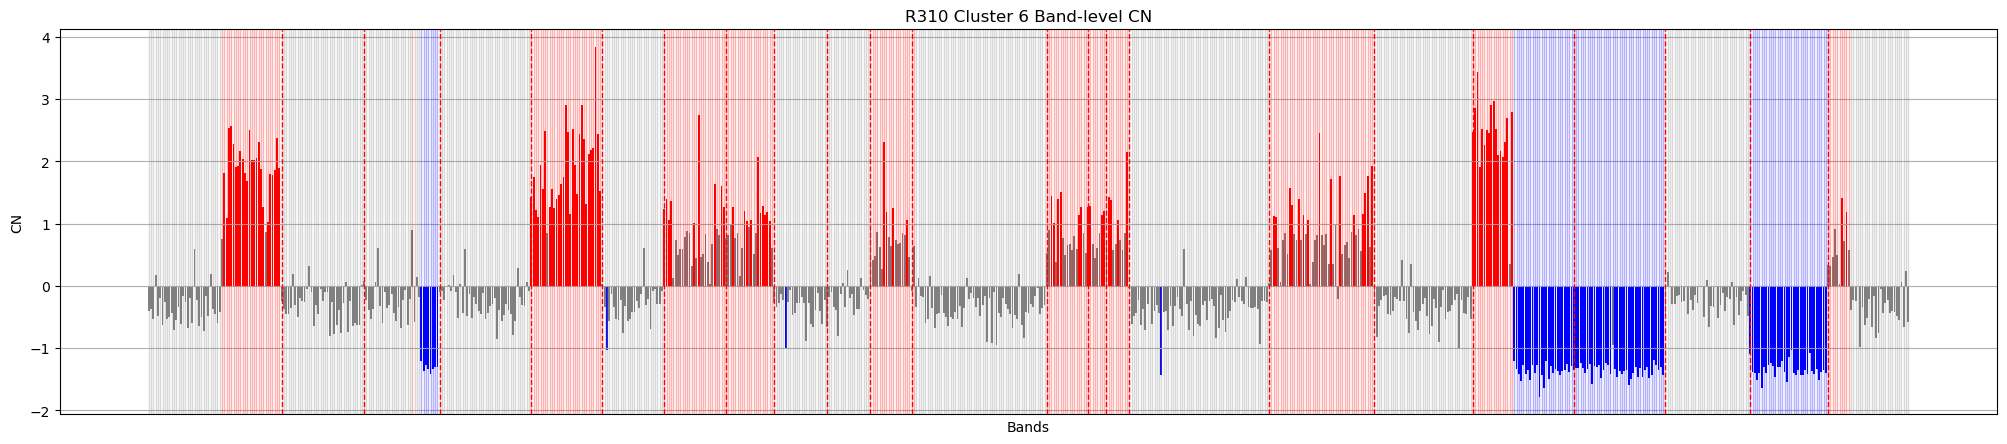

In [174]:
plt.figure(figsize=(25,5))
bar_width = 0.8

# Calculate the x positions for the bars
x_positions = np.arange(len(vals))

flipped = []
for i in states:
    if i=="neut":
        flipped.append('grey')
    elif i=="amp":
        flipped.append('red')
    else:
        flipped.append('blue')
#for i in range(len(x_positions)):
#    plt.plot([x_positions[i],x_positions[i]],[0,flipped[i]])

for i in range(len(flipped)):
    plt.axvline(x=x_positions[i], color=flipped[i], linestyle='-', alpha=0.3, linewidth=1)
    

colors = []
for i in vals:
    if i>=1:
        colors.append('r')
    elif i<1 and i>-1:
        colors.append('grey')
    else:
        colors.append('b')
# Create the bar plot
plt.bar(x_positions, vals, width=bar_width, color=colors)

# Set the x-axis ticks and labels
plt.xticks([])

for x in draw_lines:
    plt.axvline(x=x, color='r', linestyle='--', linewidth=1)  # Draw vertical line at each x-coordinate


#plt.scatter(x_positions,scipy.stats.zscore(states))
    
plt.xlabel('Bands')
plt.ylabel('CN')
plt.title('R310 Cluster 6 Band-level CN')
plt.grid(True)

plt.show()

In [175]:
vals, draw_lines, genes = bin_by_bands(infer_heatmap, '6')

vals = scipy.stats.zscore(vals)
states = get_states(np.asarray(vals))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


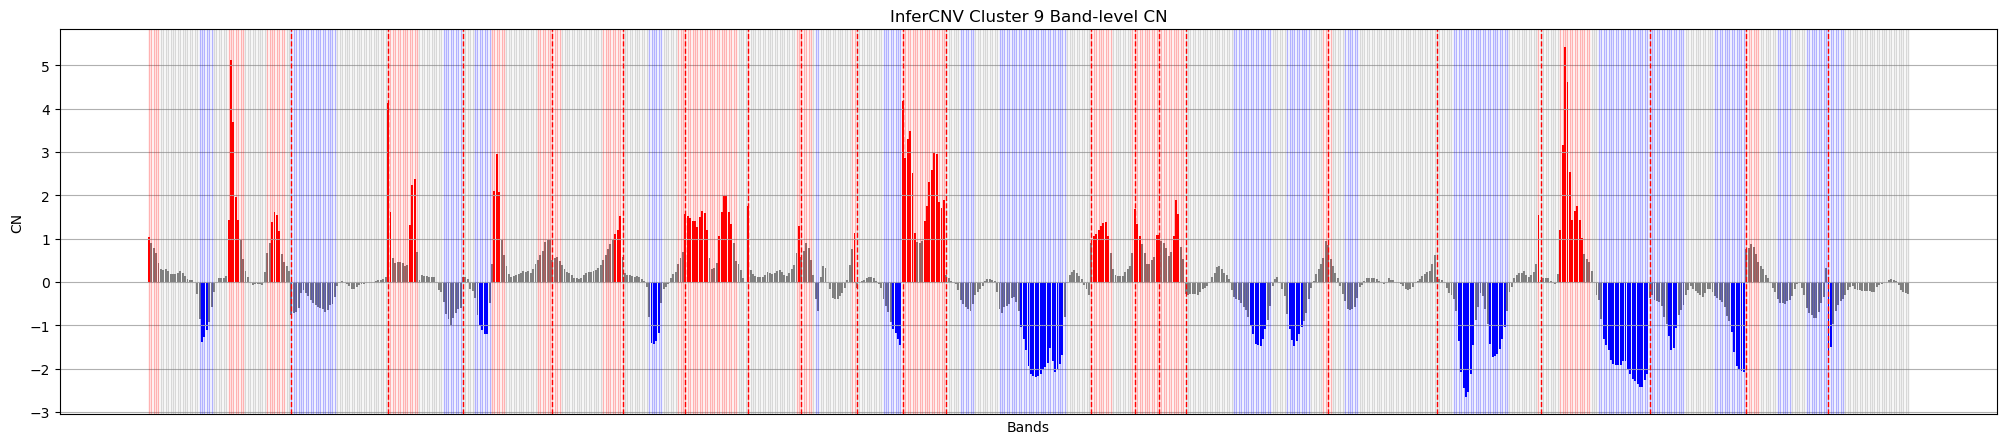

In [176]:
plt.figure(figsize=(25,5))
bar_width = 0.8

# Calculate the x positions for the bars
x_positions = np.arange(len(vals))

flipped = []
for i in states:
    if i=="neut":
        flipped.append('grey')
    elif i=="amp":
        flipped.append('red')
    else:
        flipped.append('blue')
#for i in range(len(x_positions)):
#    plt.plot([x_positions[i],x_positions[i]],[0,flipped[i]])

for i in range(len(flipped)):
    plt.axvline(x=x_positions[i], color=flipped[i], linestyle='-', alpha=0.3, linewidth=1)
    

colors = []
for i in vals:
    if i>=1:
        colors.append('r')
    elif i<1 and i>-1:
        colors.append('grey')
    else:
        colors.append('b')
# Create the bar plot
plt.bar(x_positions, vals, width=bar_width, color=colors)

# Set the x-axis ticks and labels
plt.xticks([])

for x in draw_lines:
    plt.axvline(x=x, color='r', linestyle='--', linewidth=1)  # Draw vertical line at each x-coordinate


#plt.scatter(x_positions,scipy.stats.zscore(states))
    
plt.xlabel('Bands')
plt.ylabel('CN')
plt.title('InferCNV Cluster 9 Band-level CN')
plt.grid(True)

plt.show()

In [103]:
big_etas = {}
PATH = "params2/"
for patient in os.listdir("params2/"):
    if "_" not in patient:
        print(patient)
        path = os.path.join(PATH, patient)
        eta = pd.read_csv(os.path.join(path + "/eta.csv"), index_col=0)
        ad = sc.read_h5ad(os.path.join(path + "/X.h5"))

        obs = ad.obs
        clusters = np.unique(obs["leiden"])
        
        patient_res = pd.DataFrame()
        for i in clusters:
            vals, draw_lines, genes = bin_by_bands(eta, i)
            states = get_states(np.asarray(vals))
            res = pd.DataFrame({"eta":states})
            res["cluster"] = [i for j in range(res.shape[0])]
            res["patient"] = [patient for j in range(res.shape[0])]
            res["genes"] = genes
            patient_res = pd.concat((patient_res,res),axis=0)
        big_etas[patient] = patient_res

F16
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructio

ValueError: Length of values (0) does not match length of index (670)

In [104]:
genes

array([], dtype=object)